# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LinearRegression
from sklearn import metrics

import seaborn as sns
%matplotlib inline

In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


# DATA CLEANSING: 

+ Cleaning and preparing the data will ensure that all incorrect and missing values are handled appropriately. 

+ This model will not be looking at the recon fields as this is not real time data and is therefore not appropriate for predictive modelling.

+ Futhermore, the model will not be looking at **CUST_ID** as this field will not provide any value to the model. 

In [3]:
# Dropping irrelevant columns
churn_clean = churn.drop(['CUST_ID', 'RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH', 'RECON_EMAIL_NEXT_MTH'], axis=1)

In [4]:
churn_clean.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,
1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA
2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW
3,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA
4,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC
5,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW


Now that all the unnecessary columns have been dropped, it is important to check for any outliers or missing values. The description of the clean dataset below highlights outliers the in the **AGE** column. It indicates that the minimum age is -4 which is impossible. It also states that the maximum age is 116, which *may* be possible but is very unlikely. 

For this project it is assumed that the youngest a mobile customer can be 15, while the oldest may be 95.

In [5]:
churn_clean.describe()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
count,46206.000000,46206.000000,46130.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000
mean,45.874627,1.555707,41.411836,50.318617,51.364858,10.846708,8.237112,20.349825,15.249968,0.385015,75.188029
std,33.077927,0.835529,15.263726,51.925537,20.855419,9.769887,8.341476,8.034631,10.982958,0.486604,73.519041
min,0.000000,1.000000,-4.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000
25%,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000
50%,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000
75%,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000
max,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000


In [6]:
# Managing outliers
churn_clean = churn_clean.drop(churn.index[ (churn_clean['AGE'] > churn_clean['AGE'].median() + 55) 
                                     | (churn_clean['AGE'] < churn_clean['AGE'].median() - 25)
])

In [7]:
churn_clean.describe()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
count,46127.000000,46127.000000,46051.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000
mean,45.857003,1.554534,41.332132,50.280877,51.363718,10.844516,8.238494,20.348776,15.245908,0.385089,75.174674
std,33.077811,0.834407,15.028142,51.882547,20.856803,9.763967,8.342354,8.035850,10.984012,0.486622,73.510535
min,0.000000,1.000000,15.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000
25%,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000
50%,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000
75%,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000
max,120.000000,4.000000,95.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000


Now that the outliers have been managed, the dataset must be checked for NaN values. Age is the only one with null values and as such these will be deleted. The dataset is large enough for the null values to be deleted without it altering the data frame itself. 

In [8]:
churn_clean['AGE'].isnull().values.any()


True

In [9]:
churn_clean.dropna(subset = ['AGE'], inplace=True)

In [10]:
churn_clean['AGE'].isnull().values.any()

False

In [11]:
churn_clean.shape

(46051, 17)

In [12]:
churn_clean = churn_clean.dropna()

In [13]:
churn_clean.shape

(46050, 17)

#### The customer churn dataset is now clean and ready for exploration and modelling

# Preliminary Exploration:

In [14]:
churn_var = churn_clean.drop(['ACCT_CNT_SERVICES', 'MONTHS_OF_CONTRACT_REMAINING' , 'LAST_FX_CONTRACT_DURATION', 'PREV_CONTRACT_DURATION', 'ACCOUNT_TENURE'], axis=1)

In [15]:
churn_var.describe()

,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,CHURN_IND,MONTHLY_SPEND
count,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000
mean,41.331900,50.326688,51.359217,10.848969,0.385147,75.153997
std,15.028223,51.899890,20.855963,9.766225,0.486635,73.383971
min,15.000000,0.000000,8.180000,0.000000,0.000000,1.020000
25%,28.000000,11.000000,36.360000,3.000000,0.000000,36.360000
50%,40.000000,35.000000,54.540000,8.000000,0.000000,54.540000
75%,52.000000,69.000000,72.720000,16.000000,1.000000,84.530000
max,95.000000,259.000000,234.540000,147.000000,1.000000,1965.890000


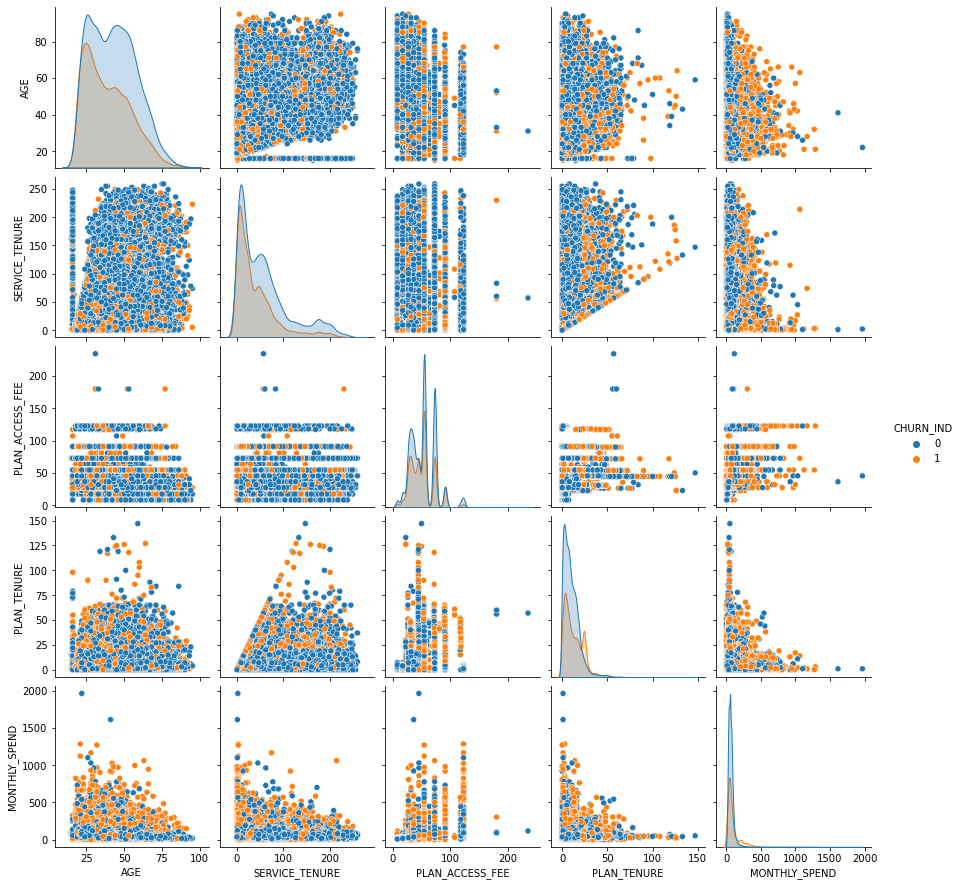

In [16]:
sns.pairplot(churn_var, hue ='CHURN_IND')

The above pairplot examines the relationship between the quantitative data in the dataset. It is sorted by the **CHURN_IND**. The plots above show that there is no linear relationship between any of the variables. As such, using linear regression for this set would not be appropriate. The correlation tables below also highlight that there is no direct relationship between sample variables and the churn index. 

In [17]:
correlation_matrix = churn_clean.corr()
correlation_matrix["CHURN_IND"]

ACCOUNT_TENURE                 -0.151409
ACCT_CNT_SERVICES              -0.062179
AGE                            -0.116637
SERVICE_TENURE                 -0.153616
PLAN_ACCESS_FEE                -0.037032
PLAN_TENURE                     0.141839
MONTHS_OF_CONTRACT_REMAINING   -0.247639
LAST_FX_CONTRACT_DURATION      -0.066641
PREV_CONTRACT_DURATION         -0.064069
CHURN_IND                       1.000000
MONTHLY_SPEND                   0.187995
Name: CHURN_IND, dtype: float64

There is no correlation between **CHURN_IND** and any other variable

Each state has outliers in relation to account tenure however roughly, each state has generally similar distributions. This is excluding Tasmania which has lower quartiles and a lower median. There is no distinct relationship between CHURN IND and account tenure as it seems to be spread evenly across the violin plot. 

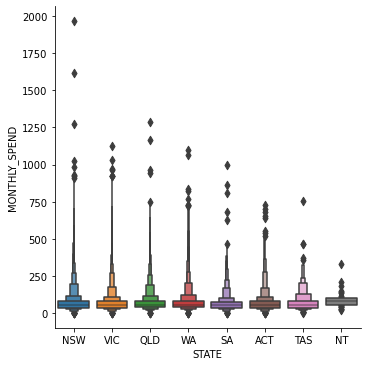

In [18]:
sns.catplot(x="STATE", y="MONTHLY_SPEND", kind="boxen", data=churn_clean.sort_values("CHURN_IND"))

While there are outliers for monthly spend, the states once again follow roughly the same distribution.

# LOGISTIC REGRESSION 

In [19]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_selection import RFE

In [20]:
train, test = train_test_split(churn_clean, test_size = 0.2, random_state = 1234)
print(train.shape)
print(test.shape)

(36840, 17)
(9210, 17)


In [21]:
x_train = train.drop(['CHURN_IND', 'CFU', 'BYO_PLAN_STATUS', 'CONTRACT_STATUS', 'HANDSET_USED_BRAND', 'COUNTRY_METRO_REGION', 'STATE'], axis = 1)
x_test = test.drop(['CHURN_IND', 'CFU', 'BYO_PLAN_STATUS', 'CONTRACT_STATUS', 'HANDSET_USED_BRAND', 'COUNTRY_METRO_REGION', 'STATE'], axis = 1)

y_train = train['CHURN_IND']
y_test = test['CHURN_IND']

In [22]:
reg = LogisticRegression(max_iter=50000)
reg.fit(x_train, y_train)

LogisticRegression(max_iter=50000)

In [23]:
train_preds = reg.predict(x_train)
test_preds = reg.predict(x_test)

In [24]:
print("Train Accuracy:")
print(accuracy_score(y_train, train_preds ))
print("Test Accuracy:")
print(accuracy_score(y_test, test_preds ))

Train Accuracy:
0.7084961997828447
Test Accuracy:
0.7102062975027145


An accuracy of 70% is not great but it's not terrible. The issue is that the test accuracy is higher than the train accuracy, meaning that the model is not accurate.

In [25]:
confusion_matrix(y_test, test_preds)

array([[4595, 1023],
       [1646, 1946]])

The confusion matrix highlights there are 1023 false positives and 1646 false negatives. Meaning that the model predicted a customer churned when they did not 1023 times and that a customer did not churn when they actually did 1646 times. This greatly impacts the model and highlights that it's not accurate.

In [26]:
train_pred = reg.predict(x_train)
test_pred = reg.predict(x_test)

print("Train MSE",mean_squared_error(y_train, train_pred) )
print("Train R Squared",r2_score(y_train, train_pred))
print ("\n")
print("Test MSE",mean_squared_error(y_test, test_pred) )
print("Test R Squared",r2_score(y_test, test_pred))

Train MSE 0.2915038002171553
Train R Squared -0.2324289557272441


Test MSE 0.28979370249728553
Test R Squared -0.21812018876646078


## EVALUATION
The training MSE is higher than the testing MSE meaning that the points the model predicts has moved further away from the regression line. Although it is not a far distance as the MSE is quite low, ideally the model should improve the MSE. 

The R-squared is very low for both training and testing sets but it is lower for the training set which is not good. Ideally the R-squared value should be much higher, especially for the training set. 

# RFE

In [27]:
lr = LogisticRegression(max_iter = 50000) 
rfe = RFE(estimator = lr, n_features_to_select = 5, step = 1)
rfe.fit(x_train, y_train)

RFE(estimator=LogisticRegression(max_iter=50000), n_features_to_select=5)

In [28]:
x_train.columns[rfe.support_]

Index(['ACCOUNT_TENURE', 'AGE', 'MONTHS_OF_CONTRACT_REMAINING',
       'LAST_FX_CONTRACT_DURATION', 'MONTHLY_SPEND'],
      dtype='object')

In [29]:
rfe.ranking_

array([1, 3, 1, 6, 4, 2, 1, 1, 5, 1])

In [30]:
train_preds = rfe.predict(x_train)
test_preds = rfe.predict(x_test)

In [31]:
print("Train Accuracy:")
print(accuracy_score(y_train, train_preds ))
print("Test Accuracy:")
print(accuracy_score(y_test, test_preds ))

Train Accuracy:
0.7045874049945711
Test Accuracy:
0.7031487513572204


Train accuracy is ****SLIGHTLY**** better than test accuracy

In [32]:
train_acc = list()
test_acc = list()

for i in range(1, x_train.shape[1]):
    lr = LogisticRegression(max_iter = 50000) 
    rfe = RFE(estimator = lr, n_features_to_select = i, step = 1)
    rfe.fit(x_train, y_train)
    train_preds = rfe.predict(x_train)
    test_preds = rfe.predict(x_test)
    train_acc.append(accuracy_score(y_train, train_preds ))
    test_acc.append(accuracy_score(y_test, test_preds ))
    
    print("Train Accuracy:")
    print(accuracy_score(y_train, train_preds ))
    print("Test Accuracy:")
    print(accuracy_score(y_test, test_preds ))

Train Accuracy:
0.636400651465798
Test Accuracy:
0.6406080347448425
Train Accuracy:
0.6629207383279044
Test Accuracy:
0.6559174809989142
Train Accuracy:
0.6644408251900109
Test Accuracy:
0.6586319218241042
Train Accuracy:
0.663870792616721
Test Accuracy:
0.6596091205211726
Train Accuracy:
0.7045874049945711
Test Accuracy:
0.7031487513572204
Train Accuracy:
0.7043702497285559
Test Accuracy:
0.7057546145494028
Train Accuracy:
0.7041259500542888
Test Accuracy:
0.7057546145494028
Train Accuracy:
0.7073561346362649
Test Accuracy:
0.7074918566775245
Train Accuracy:
0.7061617806731814
Test Accuracy:
0.707600434310532


Text(0.5, 1.0, 'Accuracy at each number of features')

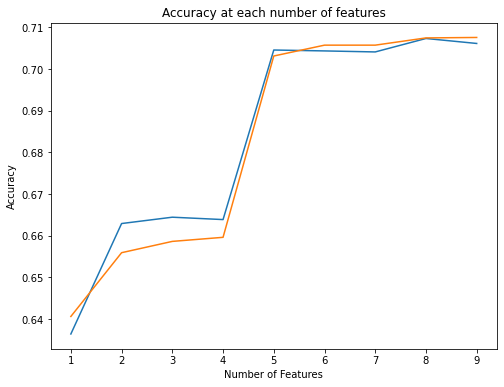

In [33]:
plt.figure(figsize=(8,6))
plt.plot(range(1, x_train.shape[1]), train_acc)
plt.plot(range(1, x_test.shape[1]), test_acc)
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Accuracy at each number of features")

The accuracy increase as the number of features increase. From 8 features onwords the accuracy seems to be consistent. The plot above highlights that the ideal number of features for this model is 8. 

In [34]:
# Set up an experiment with the data
feature_cols = np.array(['ACCOUNT_TENURE', 'AGE', 'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION', 'MONTHLY_SPEND'])
X = churn_clean[feature_cols]
y = churn_clean['CHURN_IND']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
estimator = LinearRegression()
selector = RFE(estimator, 8)  # select 8 features 
selector = selector.fit(X, y)

supp = selector.get_support()
print("Selected features:", feature_cols[supp])
print("Coeffs:", selector.estimator_.coef_)
# test the model
predicted = selector.predict(X)
print("MSE:", mean_squared_error(y, predicted))
print("R^2:", r2_score(y, predicted))

Selected features: ['ACCOUNT_TENURE' 'AGE' 'MONTHS_OF_CONTRACT_REMAINING'
 'LAST_FX_CONTRACT_DURATION' 'MONTHLY_SPEND']
Coeffs: [-0.00256885 -0.00271745 -0.0231554   0.00395693  0.0016695 ]
MSE: 0.19478002794615065
R^2: 0.1774793973628137


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=8 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


MSE is very low which is good because this means that the regression line is close the the points on the model. However, R^2 is also low which is not good as it indicates that there is a large variation between variables. 

In [36]:
logreg = LogisticRegression(max_iter = 50000).fit(x_train,y_train)

In [37]:
feature_cols = ['MONTHLY_SPEND']
X = churn_clean[feature_cols]
y = churn_clean['CHURN_IND'] 
model = LinearRegression()
model.fit(X, y)
print("y = ", model.coef_, "* X + ", model.intercept_)

y =  [0.00124666] * X +  0.29145499621956106


Text(0, 0.5, 'PREDICTED CHURN IND')

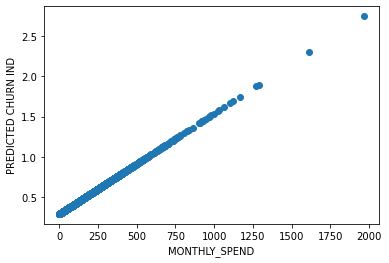

In [38]:
predicted = model.predict(X)
plt.scatter(X, predicted)
plt.xlabel('MONTHLY_SPEND');plt.ylabel('PREDICTED CHURN IND')

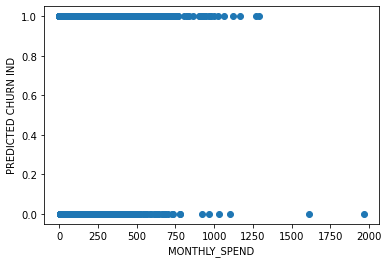

In [39]:
xr = np.array([np.arange(4.5, 8.0, 0.05)]).transpose()
predicted = model.predict(xr)
predicted = np.where(predicted >= 0.5, 1, 0)

plt.scatter(X, y); plt.plot(xr, predicted, color='red')
plt.xlabel('MONTHLY_SPEND');plt.ylabel('PREDICTED CHURN IND')
None

In [40]:
feature_cols = ['MONTHLY_SPEND']
X = churn_clean[feature_cols]
y = churn_clean['CHURN_IND']
logreg = LogisticRegression(C=1e9)
logreg.fit(X, y)

LogisticRegression(C=1000000000.0)

Text(0, 0.5, 'PREDICTED CHURN IND')

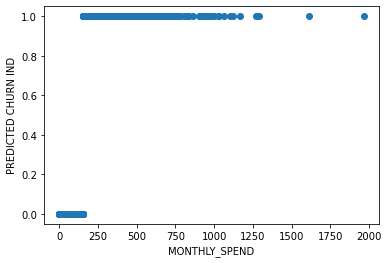

In [41]:
predicted = logreg.predict(X)
plt.scatter(X, predicted)
plt.xlabel('MONTHLY_SPEND');plt.ylabel('PREDICTED CHURN IND')

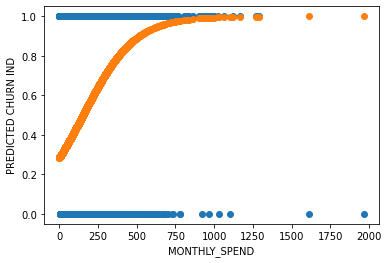

In [42]:
probs = logreg.predict_proba(X)[:, 1] 
plt.scatter(X, y); plt.scatter(X, probs)
plt.xlabel('MONTHLY_SPEND');plt.ylabel('PREDICTED CHURN IND')
None

In [43]:
table = pd.DataFrame({'probability':[0.1, 0.2, 0.25, 0.5, 0.6, 0.8, 0.9]})
table['odds'] = table.probability/(1 - table.probability)
table['logodds'] = np.log(table.odds)
table

,probability,odds,logodds
0,0.10,0.111111,-2.197225
1,0.20,0.250000,-1.386294
2,0.25,0.333333,-1.098612
3,0.50,1.000000,0.000000
4,0.60,1.500000,0.405465
5,0.80,4.000000,1.386294
6,0.90,9.000000,2.197225


# Evaluation

As the monthly spend increases, the logistic regression model predicts that the possibility of a customer churning increases. Once the monthly spend passes $750, there high predicted possibility of a customer churning. The downward curve of the normal probability plot of residuals may allude to a right skewed distribution. 


# KNEAREST NEIGHBOURS

In [44]:
# Import the KNN classifier
from sklearn.neighbors import KNeighborsClassifier

# Build a KNN classifier model
clf_knn = KNeighborsClassifier(n_neighbors=1)

# Train the model with the training data
clf_knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [45]:
x_train.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,MONTHLY_SPEND
INDEX,,,,,,,,,,
40364,60,2,33.0,11,45.45,11,13,24,24,48.45
32332,5,1,67.0,5,45.45,5,0,0,0,46.10
12934,13,2,21.0,13,72.72,13,11,24,0,439.03
20030,6,1,43.0,6,54.54,6,18,24,24,66.35
21420,79,1,26.0,79,72.72,17,7,24,24,81.81


In [46]:
# Produce the features of a testing data instance
X_new = np.array([[53, 1, 20, 33, 45.50, 14, 0, 32, 32, 55.50]])
print("X_new.shape: {}".format(X_new.shape))



X_new.shape: (1, 10)


In [47]:
# Predict the result label of X_new:
y_new_pred = clf_knn.predict(X_new)
print("Prediction: \n", y_new_pred)

Prediction: 
 [1]


In [48]:
y_pred = clf_knn.predict(x_test)

acc = accuracy_score(y_test, y_pred)

print("Test accuracy:", str(acc))


Test accuracy: 0.5314875135722041


The model predicts that the customer will churn [1]. Unfortunately it is not very accurate as it only returns an accuracy of 52%. 

In [49]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3537 2141]
 [2174 1358]]
              precision    recall  f1-score   support

           0       0.62      0.62      0.62      5678
           1       0.39      0.38      0.39      3532

    accuracy                           0.53      9210
   macro avg       0.50      0.50      0.50      9210
weighted avg       0.53      0.53      0.53      9210



The confusion matrix and classification report allows for indepth understanding of the model. 


The confusion matrix highlights that there are 2224 false positives and 2191 false negatives, which means that all of these predictions were incorrect. It means that the model predicted a customer churned 2224 times when they did not and that a customer did not churn 2191 times when they did. Furthermore, the model only returned 1341 true negatives. In which the model predicted a customer did not churn and they didn't. 

The classification report provides other insights. 
* A precision score of 0.61 for the [0] class indicates that 61% of this class was correctly identified. However a 38% precision score for the [1] class means that only 31% of the customers the model believed churned, actually churned. 

* recall and f1-score show the same results. 

* Support highlights how the results are not completely balanced between the classes. 

* With an accuracy of 52%, it can be determined that the model is not very accurate.